# Twisted $H_2$ Chain: The helical ladder
We consider an infinite chain of $H_2$ molecules - a molecular 'ladder' whose rungs are created from individual $H_2$ dimers. To this ladder, we introduce a helical twist along the longitudinal axis - 'up the ladder'. Our goals are to calculate the eigenstates and band structure of this system in an attempt to understand the effects of the twist angle on the behavior of the electrons in the system. We perform these calculations using the `kwant` quantum transport software.

### Goals
- [x] Calculate band structure and eigenstates for a system with a unit cell of arbitrary size. 
- [ ] Calculate the 'effective band structure' of the supercell system. i.e. unfold the super Brillouin zone band structure into the primitive Brillouin zone.
- [ ] Investigate how the eigenstates and band structure are affected by the twist angle.
- [ ] Calculate dipole matrix elements.

---
## System
### Hamiltonian
Kwant performs calculations in the framework of the tight-binding approximation. In this simulation we consider a system defined on a 2D rectangular Bravais lattice $$\begin{equation*}
\Lambda = \big\{ \vec{R} = n_1\vec{a}_1 + n_2\vec{a}_2 \;|\; n_1 \in \mathbb{Z}, n_2 \in (0,1) \big\}
\end{equation*}$$
with primitive lattice vectors
$$\begin{equation*}
\vec{a}_1 = (a, 0) \quad \vec{a}_2 = (0, b)
\end{equation*}$$
The general Hamiltonian for such a system takes the form
$$\begin{equation*}
H = \sum_{\Lambda}t_{n, n^\prime}|n\rangle\langle n^\prime| \quad \quad n = (n_1, n_2)
\end{equation*}$$

This general form includes all hoppings. To simplify the problem, we include only nearest and next-nearest neighbor hoppings. To accomplish this, we consider only the following non-zero hoppings in the Hamiltonian... <br>
On-site Hamiltonian $n = n^\prime$: $t_{nn} = u$ <br>
x-direction hopping $n^\prime = (n_1+1, n_2)$: $t_{n, n^\prime} = t_{n^\prime, n}^* = -v$ <br>
y-direction hopping $n^\prime = (n_1, n_2+1)$: $t_{n, n^\prime} = t_{n^\prime, n}^* = -t$ <br>
cross hoppings $n^\prime = (n_1+1, n_2+1)$: $t_{n, n^\prime} = t_{n^\prime, n}^* = -w$ <br>

### Twist angle
Twist angle along the translationally symmetric direction is modeled via scaling the hopping parameters $v,t,w$ according to the magnitude of the distance between sites as
$$\begin{align*}
v \rightarrow v/l_v^2 = v/(0.5a^2(1-\cos(\phi)) + b^2) \\
w \rightarrow w/l_w^2 = w/(0.5a^2(1+\cos(\phi)) + b^2)
\end{align*}$$
A consequence of introducing a twist angle is the need to describe the twisted system using a supercell. With a twist angle of $\phi = 2\pi/N_{\phi}$ between $H_2$ 'layers', the system now has a period of $N_{\phi}a$. Therefore, we need to use a supercell containing $N_{\phi}$ primitive unit cells. 

### Unit cell / Super cell
The standard unit cell of the $H_2$ ladder is a rectangle defined by the primitive lattice vectors $\vec{a}_1$ and $\vec{a}_2$ as defined above. Within the rectangular unit cell a basis of two $H$ atoms completes the crystal structure of the system. 

In this notebook, we consider only supercells which are simple, identical multiples of the primitive unit cell such that the size of the unit cell is scaled by a positive integer in the translationally symmetric direction
$$\begin{equation*}
a \rightarrow A = Na \quad \quad N \in \mathbb{Z}
\end{equation*}$$

---

## Defining system in `kwant`

### Package imports

In [2]:
import kwant
#from H2_ladder import hamiltonian
import numpy as np
import matplotlib.pyplot as plt

### System Parameters Definitions
`a, b`: Lattice constants <br>
`width`: Number of atoms in y-direction <br>
`N_phi`: Number of unit cells to include <br>
`hops`: (u, t, v, w) [defined above] <br>
`phi`: twist angle <br>
`G_max`: maximum SBZ reciprocal lattice vector

In [4]:
from math import pi
a = 1
b = 1
width = 2
N_phi = 5
A = N_phi*a
hops = (5,5,2,1)     # u, t, v, w
phi = pi/N_phi
N_kpts = 51
G_max = 100

In [9]:
#import kwant
from math import cos, exp

# Define the system Hamiltonian
# -----------------------------------------------------------------------------
def hamiltonian(a, b, width, hops, phi, N_phi = 1, finite = False):

    u, t, v, w = hops

    # Define the lattice
    lat_vecs = [(a,0), (0,b)]
    lat = kwant.lattice.general(lat_vecs, norbs=1)

    # Define Hamiltonian
    sys = kwant.Builder()
    if finite:
        # Create a finite sizes system to show structure
        sys[lat.shape((lambda pos: (pos[1] >= 0 and pos[1] < b*width) 
                       and (pos[0] >= 0 and pos[0] < N_phi*a)), (0,0))] = u
    else:
        # Create an infinite system for band structure calculations
        sys = kwant.Builder(kwant.TranslationalSymmetry((N_phi*a,0)))
        sys[lat.shape((lambda pos: (pos[1] >= 0 and pos[1] < b*width) 
                       and (pos[0] >= 0 and pos[0] < N_phi*a)), (0,0))] = u

    # Intra-layer hoppings
    sys[kwant.builder.HoppingKind((0,1), lat, lat)]  = -t

    # Inter-layer hoppings
    l_v = (0.5*a**2)*(1-cos(phi)) + b**2 # Modulate hopping by geometric distance due to phi
    sys[kwant.builder.HoppingKind((1,0), lat, lat)]  = -v*exp(1j*phi)/l_v

    # Cross hoppings
    l_u = (0.5*a**2)*(1+cos(phi)) + b**2
    sys[kwant.builder.HoppingKind((1,1), lat, lat)]  = -w*exp(1j*phi)/l_u
    sys[kwant.builder.HoppingKind((-1,1), lat, lat)] = -w*exp(1j*phi)/l_u

    return sys

## Initialize both unit cell and supercell systems

In [10]:
# Create the systems for the primitive cell and super cell
# -----------------------------------------------------------------------------
pc_sys = hamiltonian(a, b, width, hops, phi)
SC_sys = hamiltonian(a, b, width, hops, phi, N_phi)

# Retrieve positions
# -----------------------------------------------------------------------------
pc_pos = np.array([site.pos for site in pc_sys.sites()])
SC_pos = np.array([site.pos for site in SC_sys.sites()])
pc_sites = pc_sys.sites()
SC_sites = SC_sys.sites()

# Finalize systems for calculations
# -----------------------------------------------------------------------------
pc_sys = pc_sys.finalized()
SC_sys = SC_sys.finalized()

# Retrieve site tags for identification
# -----------------------------------------------------------------------------
pc_tags = pc_sys.id_by_site
SC_tags = SC_sys.id_by_site

TypeError: must be real number, not complex

## Reciprocal lattice & Brillouin zone
A fundamental geometric consequence of performing calculations using supercells is the 'folding' of the Brillouin zone. For the simple supercell we consider here, scaling the primitive unit cell by the factor $N_{\phi}$ folds the primitive Brillouin zone (pbz) $N_{\phi}$ times, reducing the size of the super Brillouin zone (SBZ) by a factor $1/N_{\phi}$. 

Here, we construct the unit cell and supercell reciprocal lattices and their respective Brillouin zones to visualize their geometries. 

Primitive cell lattice vectors: 
[[1 0]
 [0 1]]
Primitive cell reciprocal lattice vectors: 
[[-6.28318531  0.        ]
 [ 0.          6.28318531]]

Super cell lattice vectors: 
[[5 0]
 [0 1]]
Super cell reciprocal lattice vectors: 
[[-1.25663706  0.        ]
 [ 0.          6.28318531]]



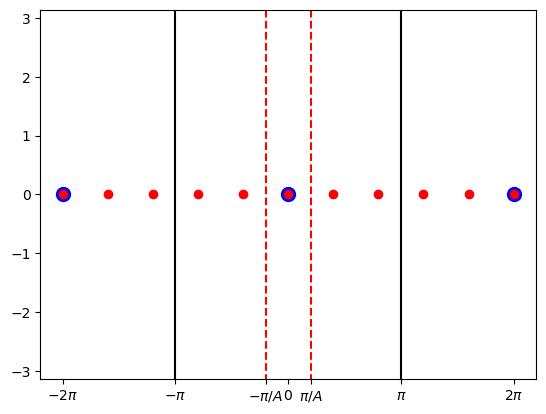

In [110]:
#%matplotlib widget
# Define a reciprocal lattice vector calculation function
# -----------------------------------------------------------------------------
def reciprocal_vecs(lattice_vectors):
    '''Returns the reciprocal lattice vectors 
    for a set of real-space lattice vectors'''
    a1, a2 = lattice_vectors
    R_90 = np.array([[0, -1],[1, 0]])
    V = np.dot(-a1,np.matmul(R_90, a2))
    b1 = (2*np.pi/V)*np.matmul(R_90, a2)
    b2 = (2*np.pi/V)*np.matmul(R_90, a1)
    return np.array([b1, b2])

# Define the primitice cell direct and reciprocal lattice vectors
# -----------------------------------------------------------------------------
pc_lat_vecs = np.array([[a, 0], [0, b]])
pc_rec_vecs = reciprocal_vecs(pc_lat_vecs)

# Define the super cell direct and reciprocal lattice vectors
# -----------------------------------------------------------------------------
M = np.array([[N_phi, 0], [0, 1]])
SC_lat_vecs = np.matmul(M, pc_lat_vecs)
SC_rec_vecs = reciprocal_vecs(SC_lat_vecs)

# Create the reciprocal lattice
# -----------------------------------------------------------------------------
g_range = range(-int(G_max/N_phi),int(G_max/N_phi))
G_range = range(-G_max,G_max)
g0 = 2*pi/a 
G0 = 2*pi/A
g = np.array([2*n*np.pi/a for n in G_range])
G = np.array([2*n*np.pi/A for n in G_range])

# Output direct and reciprocal lattice vectors
# -----------------------------------------------------------------------------
print('Primitive cell lattice vectors: \n' + str(pc_lat_vecs))
print('Primitive cell reciprocal lattice vectors: \n' + str(pc_rec_vecs) + '\n')
print('Super cell lattice vectors: \n' + str(SC_lat_vecs))
print('Super cell reciprocal lattice vectors: \n' + str(SC_rec_vecs) + '\n')

# Plot reciprocal lattices
# -----------------------------------------------------------------------------
plt.scatter(g, np.size(g)*[0], s=100, color = 'b')
plt.scatter(G, np.size(G)*[0], color = 'r')
plt.xlim(-1.1*g0,1.1*g0)
plt.ylim(-0.5*g0,0.5*g0)

# Plot Brillouin zones
# -----------------------------------------------------------------------------
plt.vlines(g0/2, -10, 10, color = 'k', zorder = 0)
plt.vlines(-g0/2, -10, 10, color = 'k', zorder = 0)
plt.vlines(G0/2, -10, 10, color = 'r', ls='--')
plt.vlines(-G0/2, -10, 10, color = 'r', ls='--')
plt.xticks([-2*np.pi, -np.pi, -np.pi/N_phi, 0, np.pi/N_phi, np.pi, 2*np.pi],
           ['$-2\pi$', '$-\pi$', '$-\pi/A$', '$0$', '$\pi/A$','$\pi$', '$2\pi$'])

plt.show()

## Wave vectors in the pbz/SBZ
The folding of wave vectors from the pbz to the SBZ is a process determined completely by the geometry and symmetries of the supercell and it's underlying primitive cell. A wave vector $\vec{k}$ in the pbz is said to fold into a wave vector $\vec{K}$ in the SBZ if there exists a supercell reciprocal lattice vector $\vec{G}$ such that
$$\begin{equation*}
\vec{K} = \vec{k} - \vec{G}
\end{equation*}$$
For our pbz/SBZ geometry we want to identify all wave vectors $\vec{K}$ which correspond to a folded $\vec{k}$. This is done by scanning through each $\vec{k}$ point in the pbz (the array `kpts`) and checking all supercell reciprocal lattice vectors $\vec{G}$ (within the finite, but large set we have defined) to see if the corresponding $\vec{K} = \vec{k} - \vec{G}$ falls within the SBZ we have defined. If the wave vector $\vec{K}$ is in the SBZ, we append that value to an array `Kpts` and the 'folding reciprocal lattice vector' $\vec{G}_i$ to an array `Gi`. Otherwise, we check another $\vec{G}$ until we have exhausted our reciprocal lattice vectors. 

In [103]:
# Define the pbz wave vectors k
# -----------------------------------------------------------------------------
# Don't include -pi exactly to avoid double counting
kpts = np.linspace(-pi, pi - (1/N_kpts), N_kpts)

# Calculate super cell K points from the pbz k points
# -----------------------------------------------------------------------------
def get_K_from_k(kpts, G_vecs, G0):
    Kpts = []
    Gi   = []
    for k in kpts:
        for G in G_vecs:
            K = k - G
            if -0.5*np.abs(G0) <= K < 0.5*np.abs(G0):
                Kpts.append(K)
                Gi.append(G)
    return np.array(Kpts), np.array(Gi)

Kpts, G_unfold = get_K_from_k(kpts, G, G0)

---
## Eigenvalues $\epsilon_n(k)$: the band structure
The band structure is calculated with a call to the `kwant.physics.Bands` object which returns all eigenvalues $\epsilon_n(k)$ for the input wave vector $k$. This function call solves the eigenvalue problem for a single Fourier component of the Schrodinger equation
$$\begin{equation*}
\big[V^{\dagger}e^{ik} + H + Ve^{-ik}\big]|u_{nk}\rangle = \epsilon_n(k)|u_{nk}\rangle
\end{equation*}$$
where $V$ represents the Hamiltonian for hoppings from one unit cell to the next (i.e. the inter-cell hoppings `sys.inter_cell_hoppings`) and $H$ represents the unit cell Hamiltonian (`sys.cell_hamiltonian`). This equation effectively ignores the length scales ($a$ or $A$) of the lattice parameters, we must input them directly by using a momenta $-\pi < ka \le \pi$ (or for the super cell $-\pi < KA \le \pi$). 

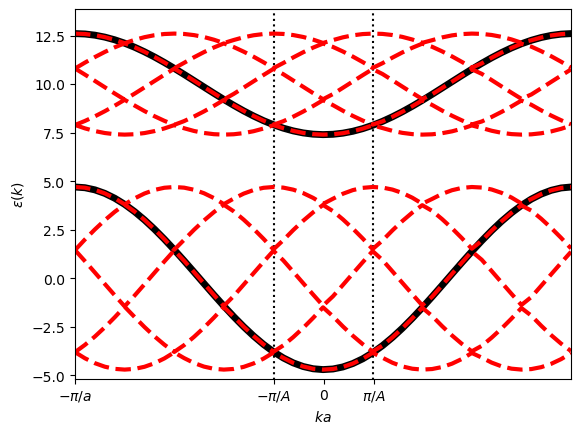

In [115]:
# Create Bands object instance for both cells
# -----------------------------------------------------------------------------
pc_bands = kwant.physics.Bands(pc_sys)
SC_bands = kwant.physics.Bands(SC_sys)

# Calculate the band structure E_n(k)
# -----------------------------------------------------------------------------
pc_energies = [pc_bands(k*a) for k in kpts]
SC_energies = [SC_bands(K*A) for K in Kpts]

# Plot the energies as a function of momenta, i.e the band structure
# -----------------------------------------------------------------------------
fig, band_ax = plt.subplots()
band_ax.plot(kpts, pc_energies, color = 'k', lw = 5)
band_ax.plot(kpts, SC_energies, color = 'r', lw = 3, ls='--', zorder = 2)
band_ax.vlines(kpts[-1]/A, -20, 20, color = 'k', ls = ':', zorder = 0)
band_ax.vlines(kpts[0]/A, -20, 20, color = 'k', ls = ':', zorder = 0)
band_ax.set_xticks([-pi/a, -pi/A, 0, pi/A, pi/a], 
                   ['$-\pi/a$', '$-\pi/A$', '0', '$\pi/A$', '$\pi/a$'])
band_ax.set_xlim(kpts[0], kpts[-1])
band_ax.set_ylim(1.1*np.min(pc_energies), 1.1*np.max(pc_energies))
band_ax.set_xlabel(r'$ka$')
band_ax.set_ylabel(r'$\epsilon(k)$')

plt.show()

## Eigenstates $|u_{nk}\rangle$
Calculating the eigenstates is done similarly: a call to `kwant.physics.Bands`, but returning for each wave vector $k$, the eigenvectors $|u_{nk}\rangle$ for each eigenvalue $\epsilon_n(k)$ as well. When calculating the unit cell eigenvectors, we extend them to the size of the supercell to be able to calculate quantities e.g. the overlap matrix between SBZ and pbz states $\langle u_{mK}|u_{nk}\rangle$.

In [105]:
# Open an output log file
log = open('output.log', 'w')
log.write('Eigenvector output \n\n')

# Solve eigenvalue problem for the super cell and primitive cell Hamiltonians
# -----------------------------------------------------------------------------
pc_enk, pc_unk, SC_enk, SC_unk = [], [], [], []

# Primitive cell 
# --------------
for k in kpts:
    # Solve eigenvalue problem for the unit cell system
    pc_eigvals, pc_eigvecs = pc_bands(k*a, return_eigenvectors = True)
    # eigvecs shape: (Norbs, Nstates)
    # eigvals shape: (Nstates, )

    # N states will be the size of the last dimension of eigvecs
    N_pc_states = np.size(pc_eigvecs, 0)

    # Output to file
    log.write('pc_eigvecs - k = {} \n'.format(k) 
                + str(pc_eigvecs) + '\n')
    for n in range(N_pc_states):
        log.write('pc_eigvecs - n = {} \n'.format(n) 
                    + str(pc_eigvecs[:,n]) + '\n')
    log.write('\n')
    
    # Append to total energy/state arrays
    pc_enk.append(pc_eigvals)
    pc_unk.append(pc_eigvecs)

# Supercell
# ---------
for K in Kpts:
    # Solve the eigenvalue problem for the super cell system
    SC_eigvals, SC_eigvecs = SC_bands(K*A, return_eigenvectors = True)

    N_SC_states = np.size(SC_eigvecs, 0)

    log.write('SC_eigvecs - k = {} \n'.format(K) + str(SC_eigvecs) + '\n')
    for n in range(N_SC_states):
        log.write('SC_eigvecs - n = {} \n'.format(n) 
                  + str(SC_eigvecs[:,n]) + '\n')
    log.write('\n')

    SC_enk.append(SC_eigvals)
    SC_unk.append(SC_eigvecs)

# NumPy array conversion
pc_enk  = np.array(pc_enk)
pc_unk  = np.array(pc_unk)
SC_enk  = np.array(SC_enk)
SC_unk  = np.array(SC_unk)

# Swap unk axis so they are indexed as (N_orbs, N_kpts, N_states)
# -----------------------------------------------------------------------------
pc_unk  = np.swapaxes(pc_unk,  0, 1)
SC_unk  = np.swapaxes(SC_unk,  0, 1)

# Output the first few eigenstates for k = 0
# -----------------------------------------------------------------------------
print('Primitive cell eigenstates \n--------------------------')
for n in range(N_pc_states):
    print('n = {}'.format(n))
    print(' E_nk = {}'.format(np.round(pc_enk[0,n])))
    print(' u_nk = {}'.format(pc_unk[:,0,n]) + '\n')
print('Supercell eigenstates \n--------------------------')
for n in range(N_SC_states):
    print('n = {}'.format(n))
    print(' E_nk = {}'.format(np.round(SC_enk[0,n])))
    print(' u_nk = {}'.format(SC_unk[:,0,n]))

Primitive cell eigenstates 
--------------------------
n = 0
 E_nk = 5.0
 u_nk = [-0.70710678+0.j -0.70710678+0.j]

n = 1
 E_nk = 13.0
 u_nk = [-0.70710678+0.j  0.70710678+0.j]

Supercell eigenstates 
--------------------------
n = 0
 E_nk = -4.0
 u_nk = [ 0.4472136+0.00000000e+00j  0.4472136-1.44898872e-33j
 -0.3618034+3.70281951e-18j -0.3618034+2.24161461e-18j
 -0.1381966+6.57744457e-18j -0.1381966+2.37364019e-18j
  0.1381966-1.03467580e-17j  0.1381966-1.45505623e-17j
  0.3618034-4.06053179e-17j  0.3618034-4.20665228e-17j]
n = 1
 E_nk = -4.0
 u_nk = [ 8.73072671e-17+0.00000000e+00j  7.40530421e-17-5.70995693e-18j
 -2.57033008e-01+5.50666261e-02j -2.57033008e-01+5.50666261e-02j
 -4.15888143e-01+8.90996727e-02j -4.15888143e-01+8.90996727e-02j
 -4.15888143e-01+8.90996727e-02j -4.15888143e-01+8.90996727e-02j
 -2.57033008e-01+5.50666261e-02j -2.57033008e-01+5.50666261e-02j]
n = 2
 E_nk = 1.0
 u_nk = [ 0.01159166+0.00000000e+00j  0.01159166+1.63141627e-17j
 -0.31787795+2.78286998e-01j -0.3

## Visualizing the constructed $u_{nk}(\vec{r}) = \langle \vec{r}|u_{nk}\rangle$
To visualize the calculated eigenstates, we plot them as images using `pyplot.imshow` with the value of the orbital at each lattice site being represented by color. This technique is purely a visualization to aid in understanding the structure of the eigenstates and not very representative of the tight-binding wave functions which are perfectly localized in space.

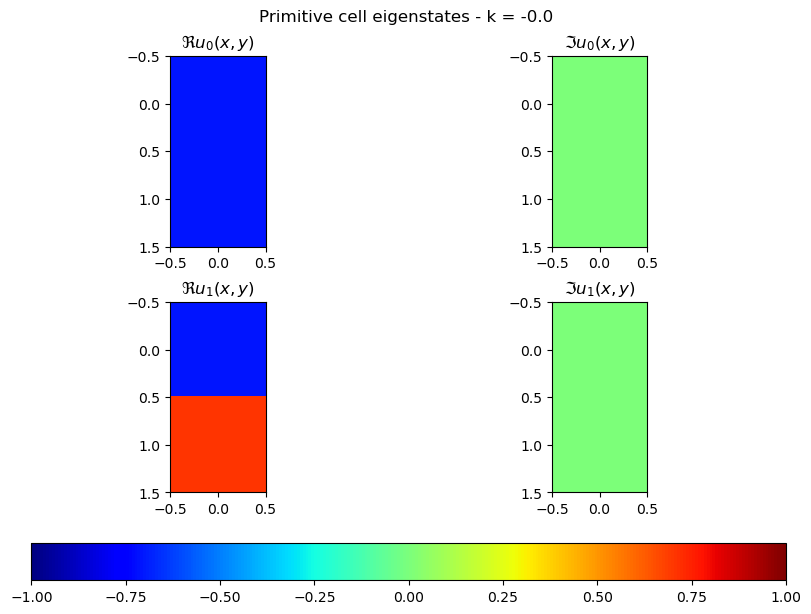

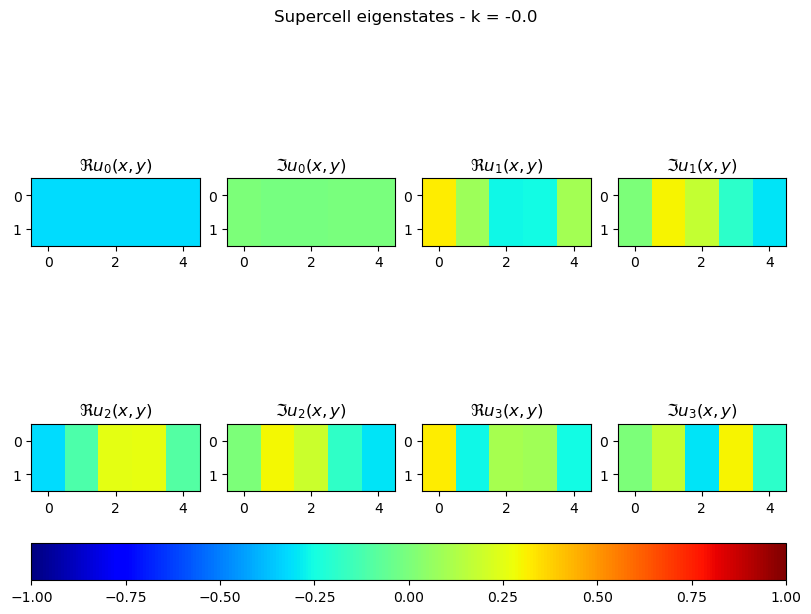

In [106]:
# k = 0
k0 = int(N_kpts/2)

# Plot the primitive cell eigenstate
# -----------------------------------------------------------------------------
fig = plt.figure(figsize = (8,6), layout='constrained')
ax_pc_unk = []
for n in range(N_pc_states):
    # Pick out n-th eigenval/vec
    energy = pc_enk[k0, n]
    state  = np.array(np.array_split(pc_unk[:, k0, n], 1))

    # Plot onto real and imaginary axes
    ax_re = fig.add_subplot(2, N_pc_states, 2*n+1)
    ax_im = fig.add_subplot(2, N_pc_states, 2*(n+1))
    ax_re.set_title('$\Re u_{}(x,y)$'.format(n))
    ax_im.set_title('$\Im u_{}(x,y)$'.format(n))
    plot_unk = ax_re.imshow(np.real(state).transpose(), 
                            vmin=-1, vmax = 1, cmap = 'jet')
    plot_unk = ax_im.imshow(np.imag(state).transpose(), 
                            vmin=-1, vmax = 1, cmap = 'jet')

    # Add axes to array for colorbar placement
    ax_pc_unk.append(ax_re)
    ax_pc_unk.append(ax_im)

# Create the color bar
fig.colorbar(plot_unk, ax = ax_pc_unk[:], location = 'bottom')
fig.suptitle('Primitive cell eigenstates - k = {}'.format(np.round(kpts[k0])))

# Plot the supercell eigenstates
# -----------------------------------------------------------------------------
fig = plt.figure(figsize = (8,6), layout='constrained')
ax_SC_unk = []
N_SC_states = 4
for n in range(N_SC_states):
    # Pick out n-th eigenval/vec
    energy = SC_enk[k0, n]
    state  = np.array(np.array_split(SC_unk[:, k0, n], N_phi))

    # Create axes, set titles
    ax_re = fig.add_subplot(2, N_SC_states, 2*n+1)
    ax_im = fig.add_subplot(2, N_SC_states, 2*(n+1))
    ax_re.set_title('$\Re u_{}(x,y)$'.format(n))
    ax_im.set_title('$\Im u_{}(x,y)$'.format(n))

    # Plot the image
    plot_unk = ax_re.imshow(np.real(state).transpose(), 
                            vmin=-1, vmax = 1, cmap = 'jet')
    plot_unk = ax_im.imshow(np.imag(state).transpose(), 
                            vmin=-1, vmax = 1, cmap = 'jet')

    # Add axes to array for colorbar placement
    ax_SC_unk.append(ax_re)
    ax_SC_unk.append(ax_im)

# Create the color bar
fig.colorbar(plot_unk, ax = ax_SC_unk[:], location = 'bottom')
fig.suptitle('Supercell eigenstates - k = {}'.format(np.round(Kpts[k0])))

plt.show()

## Bloch states
Now that we have the $u_{nk}(\vec{r})$ for a single unit cell, we may construct the Bloch states for the infinite system as a plane-wave modulation of the $u_{nk}(\vec{r})$
$$\begin{equation}
\psi_{nk}(\vec{r}) = e^{i\vec{k}\cdot\vec{r}}u_{nk}(\vec{r})
\end{equation}$$
where we take $k_y = 0$ so we have $\vec{k} = k_x$ and we calculate
$$\begin{equation}
\psi_{nk}(x,y) = e^{ik_x x}u_{nk}(x,y)
\end{equation}$$
Since we only have the eigenstate for a single unit cell up to this point, to calculate the Bloch state we extend the unit cell eigenstates in the translationally symmetric direction (i.e. x-direction in our case) to an arbitrary length $N_{ext}$ and modulate this extended state with the plane-wave. 

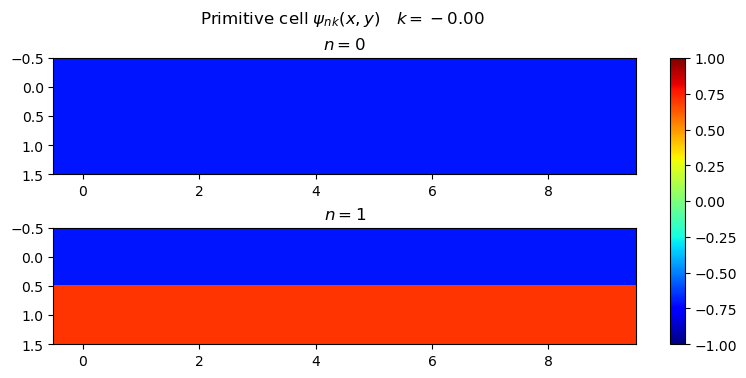

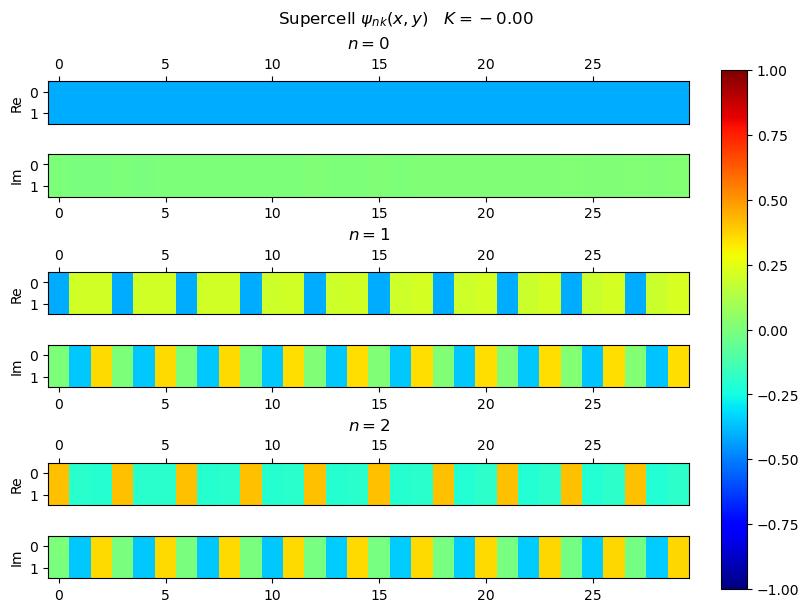

In [16]:
# Extend the u_nk over an arbitrary range in the x-direction
# -----------------------------------------------------------------------------
N_ext = 10
SC_unk_, pc_unk_ = [], []
for _ in range(N_ext):
    pc_unk_.append(pc_unk)
    for nc in range(N_phi):
        SC_unk_.append(SC_unk[nc*width:(nc+1)*width,:,:])
SC_unk_ = np.array(SC_unk_)
pc_unk_ = np.array(pc_unk_)

# Calculate the Bloch states by modulating the extended u_nk by a plane wave
# -----------------------------------------------------------------------------
pc_psi_nk = np.zeros((N_ext, width, N_kpts, N_pc_states), dtype=complex)
SC_psi_nk = np.zeros((N_ext*N_phi, width, N_kpts, N_SC_states), dtype=complex)
for ni in range(N_pc_states):
    for ki, k in enumerate(kpts):
        for xi in range(N_ext):
            pc_psi_nk[xi, :, ki, ni] += np.exp(1j*k*xi)*pc_unk_[xi, :, ki, ni]

for ni in range(N_SC_states):
    for ki, k in enumerate(kpts):
        k /= N_phi
        for xi in range(N_ext*N_phi):
            SC_psi_nk[xi, :, ki, ni] += np.exp(1j*k*xi)*SC_unk_[xi, :, ki, ni]

# Plot the Bloch states
# -----------------------------------------------------------------------------
ki = k0 # At the gamma point

# Primitive cell
# -------------------------------------------------------
fig = plt.figure(figsize = (8,6), layout = 'constrained')
ax_pc_psi = []
for n in range(N_pc_states):
    ax = fig.add_subplot(4,1,n+1)
    state = pc_psi_nk[:,:,ki,n].real.T

    #ax.set_title('$n = {}, \quad E_{} = {:3.2f}$'.format(n, n, SC_enk[n]))
    plot_psi = ax.imshow(state, vmin=-1, vmax = 1, cmap = 'jet')
    ax.set_title('$n = {}$'.format(n))
    ax_pc_psi.append(ax)

fig.colorbar(plot_psi, ax = ax_pc_psi[:], location = 'right')
fig.suptitle('Primitive cell $\psi_{nk}(x,y)\quad' 
             + 'k = {:3.2f}$'.format(kpts[ki]))

# Supercell 
# -------------------------------------------------------
fig = plt.figure(figsize = (8,6), layout = 'constrained')
ax_SC_psi = []
N_SC_states = 3
for n in range(N_SC_states):
    # Create subplots for real and imag parts
    re_ax = fig.add_subplot(2*N_SC_states,1,2*n+1)
    im_ax = fig.add_subplot(2*N_SC_states,1,2*n+2)
    
    # Extract the real and imag parts of the state
    re_state = SC_psi_nk[:,:,ki,n].real.T
    im_state = SC_psi_nk[:,:,ki,n].imag.T

    # Plot the states
    re_plot_psi = re_ax.imshow(re_state, vmin=-1, vmax=1, cmap = 'jet')
    im_plot_psi = im_ax.imshow(im_state, vmin=-1, vmax=1, cmap = 'jet')
    re_ax.set_title('$n = {}$'.format(n))
    re_ax.set_ylabel('Re')
    im_ax.set_ylabel('Im')
    re_ax.xaxis.tick_top()
    ax_SC_psi.append(re_ax)
    ax_SC_psi.append(im_ax)

fig.colorbar(re_plot_psi, ax = ax_SC_psi[:], location = 'right')
fig.suptitle('Supercell $\psi_{nk}(x,y)\quad' 
            + 'K = {:3.2f}$'.format(Kpts[ki]))

plt.show()

## Delta function approximation of $|u_{nk}\rangle$
The previous visualization is not a good representation of the true tight-binding eigenstates, which are highly localized in space
$$\begin{equation*}
u_{nk}(\vec{r}) = \sum_i^{sites} \phi_i \delta(\vec{r} - \vec{r}_i)
\end{equation*}$$
where $\phi_i$ represents the orbital value at site $i$. We therefore construct a more faithful representation of the tight-binding eigenstate by approximating this functional form. We employ the Lorentzian approximation of the delta function, which for two-dimensions takes the form
$$\begin{equation*}
\delta(\vec{r} - \vec{r}_i) = \lim_{\eta \rightarrow 0} \frac{1}{2\pi} \frac{\eta}{((x-x_i)^2 + (y-y_i)^2 + \eta^2)^{3/2}}
\end{equation*}$$
However, we want a 'delta-like' function which has an amplitude of $1$ at $\vec{r} = \vec{r}_i$. This functional form is achieved by multiplying the above form by $\eta^2$. This is no longer a true delta function, but serves the purpose of recreating a highly-localized state at each lattice site whose amplitude can be scale to that of the orbital value at each site. 

In [92]:
# Build a 'continuous' grid of points
# -----------------------------------------------------------------------------
N_grid = 100
x_min, x_max = np.min(SC_pos[:,0]), np.max(SC_pos[:,0])
y_min, y_max = np.min(SC_pos[:,1]), np.max(SC_pos[:,1])
x_range, y_range = x_max - x_min, y_max - y_min
x_step, y_step = x_range/N_grid, y_range/N_grid
xgrid = np.arange(x_min, x_max, x_step)
ygrid = np.arange(y_min, y_max, y_step)

# Calculate the delta-function state on the grid
# -----------------------------------------------------------------------------
eta = 0.2
SC_unk_d = np.zeros((N_grid, N_grid, N_kpts, N_SC_states), dtype=complex)
for site in SC_sites:
    x0, y0 = site.pos[0], site.pos[1]
    for xi, x in enumerate(xgrid):
        for yi, y in enumerate(ygrid):
            SC_unk_d[xi,yi,:,:] += SC_unk[SC_tags[site],:,:]*((eta**3)
                                /((x-x0)**2 + (y-y0)**2 + eta**2)**(1.5))

# Plot the state as an image
# -----------------------------------------------------------------------------
fig = plt.figure(figsize = (8,6), layout='constrained')
ax_del_unk = []
for n in range(N_SC_states):
    ax_del_re = fig.add_subplot(2, N_SC_states, 2*n+1)
    ax_del_im = fig.add_subplot(2, N_SC_states, 2*(n+1))
    plot_delta= ax_del_re.imshow(SC_unk_d[:,:,k0,n].real.T, 
                vmin = -0.5, vmax = 0.5,
                extent = [x_min, x_max, y_min, y_max],
                cmap = 'jet')
    plot_delta= ax_del_im.imshow(SC_unk_d[:,:,k0,n].imag.T, 
                vmin = -0.5, vmax = 0.5,
                extent = [x_min, x_max, y_min, y_max],
                cmap = 'jet')
    ax_del_re.set_title('$\Re u_{}(x,y)$'.format(n))
    ax_del_im.set_title('$\Im u_{}(x,y)$'.format(n))
    ax_del_unk.append(ax_del_re)
    ax_del_unk.append(ax_del_im)
fig.suptitle('$\delta$ function approximation of $\psi_{nk}$')
fig.colorbar(plot_delta, ax=ax_del_unk)

plt.show()

ValueError: operands could not be broadcast together with shapes (101,3) (101,18) (101,3) 

---
## Band structure unfolding

Now that we have the band structure and eigenstates calculated, we are now prepared to unfold the supercell band structure into an effective band structure defined over the pbz. The technique we will use is taken from an article by [Popescu/Zunger](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.85.085201). In this method, we project the SBZ states $|Km\rangle = |u_{mK}\rangle$ onto all the pbz states $|kn\rangle = |u_{nk}\rangle$ of a fixed wave vector $k$ and calculating the spectral weight
$$\begin{equation*}
P_{Km}(k) = \sum_n |\langle Km|kn \rangle|^2
\end{equation*}$$
This quantity represents the probability of finding a set of primitive cell $\{|kn\rangle\}$ states contributing to the supercell state $|Km\rangle$, or, equivalently, the amount of Bloch character $k$ preserved in $|Km\rangle$ at the same energy $\epsilon_n = \epsilon_m$. It can be shown that if we consider a plane-wave expansion of the eigenstates 
$$\begin{equation*}
u_{mK}(\vec{r}) = \sum_{\vec{G}}C_{mK}(\vec{G})e^{i\vec{G}\cdot\vec{r}} \longleftrightarrow C_{mK}(\vec{G}) = \sum_{\vec{r}} u_{mK}(\vec{r})e^{-i\vec{G}\cdot\vec{r}}
\end{equation*}$$
then the quantity $P_{Km}(k)$ can be expressed purely in terms of the supercell fourier components $C_{mK}$
$$\begin{equation*}
P_{mK}(\vec{k}) = \sum_{\vec{g}} |C_{mK}(\vec{g} + \vec{k} - \vec{K})|^2
\end{equation*}$$


From this quantity, we may then calculate a spectral function
$$\begin{equation*}
A(k, \epsilon) = \sum_m P_{Km}(k) \delta(\epsilon_m - \epsilon)
\end{equation*}$$
which now serves as our desired effective band structure. To approximate the [Dirac delta function](https://mathworld.wolfram.com/DeltaFunction.html) in this expression, we use the definition of it in terms of a limit of a Lorentzian
$$\begin{equation*}
\delta(\epsilon_{m} - \epsilon) = \lim_{\eta \rightarrow 0}\frac{1}{\pi}\frac{\eta}{(\epsilon_m - \epsilon)^2 + \eta^2}
\end{equation*}$$
and choose a small, finite $\eta$

### Calculating the plane-wave expansion

The plane-wave expansion of the eigenstates is a type of Fourier transform
$$\begin{equation}
C_{mK}(\vec{G}) = \sum_{\vec{r}}u_{mK}(\vec{r})e^{-i\vec{G}\cdot \vec{r}}
\end{equation}$$
The end goal of these expansions is to calculate a probability which must be normalized, therefore normalization of this transform is not necessary at this stage. Since we only have translational symmetry in the x-direction, we actually want to perform a 'partial' Fourier transform in the sense of only tranforming the x dependent part of the function
$$\begin{equation}
C_{mK}(G_x, y) = \sum_{x,y}u_{mK}(x,y)e^{-iG_xx}
\end{equation}$$

In [75]:
# Calculate plane-wave expansion of supercell eigenstate
# -----------------------------------------------------------------------------
C_mK = np.zeros((np.size(G), np.size(xgrid), N_kpts, N_SC_states), dtype=complex)
for Gi, G_ in enumerate(G):
    for yi, y in enumerate(ygrid):
        for xi, x in enumerate(xgrid):
            C_mK[Gi,yi,:,:] += SC_unk_d[xi,yi,:,:]*np.exp(-1j*G_*x)
# shape(C_mK) = (N_G, N_grid, N_Kpts, N_SC_states)

C_mK = np.array(C_mK)

### Plot the Fourier components

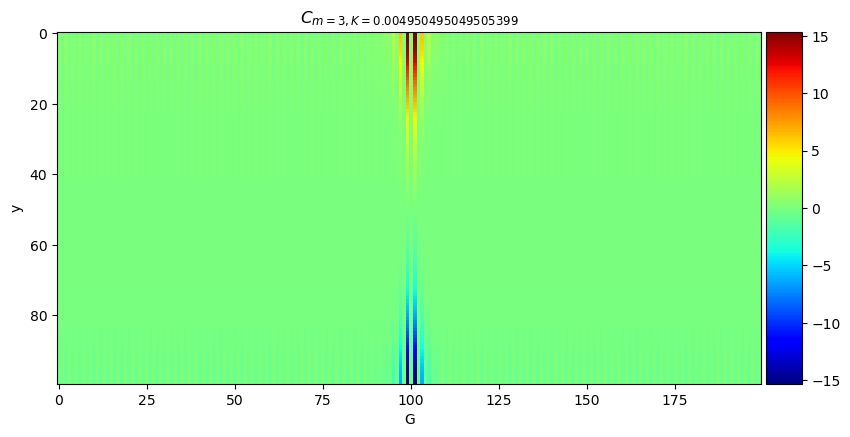

In [76]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

n = 3

fig = plt.figure(figsize=(8,6), layout='constrained')
ax = fig.add_subplot()

im = ax.imshow(C_mK[:,:,k0,n].real.T, cmap='jet')
ax.set_xlabel('G')
ax.set_ylabel('y')
ax.set_title('$C_{{m={}, K={}}}$'.format(n, Kpts[k0]))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax)

### Does the plane-wave expansion yield the eigenstates in the inverse?
Of course, the Fourier transform is an invertible process. Therefore, the best check to its correct calculation is seeing if the inverse Fourier transform yields the original input function. 
$$\begin{equation}
u_{mK}(\vec{r}) = \sum_{\vec{G}}C_{mK}(\vec{G})e^{i\vec{G}\cdot\vec{r}} 
\end{equation}$$
or in terms of the 'partial' Fourier tranform we are using
$$\begin{equation}
u_{mK}(x,y) = \sum_{G_x}C_{mK}(G_x, y)e^{-iG_xx}
\end{equation}$$

In [77]:
pw_unk = np.zeros((np.size(xgrid), np.size(ygrid), N_kpts, N_SC_states), dtype = complex)
norm = 1/(np.size(G))
for Gi, G_ in enumerate(G):
    for xi, x in enumerate(xgrid):
        for yi, y in enumerate(ygrid):
            pw_unk[xi, yi, ...] += norm*C_mK[Gi, yi, ...]*np.exp(1j*G_*x)
pw_unk = np.array(pw_unk)
print(np.min(pw_unk[:,:,k0,0]))

(-0.5089095788342417+0.0024939079527306523j)


In [78]:
# n = 3

# fig = plt.figure(figsize=(8,6), layout='constrained')
# ax = fig.add_subplot()

# im = ax.imshow(pw_unk[:,:,k0,n].real.T,
#                extent = [x_min, x_max, y_min, y_max],
#                cmap='jet')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# #ax.set_title('$C_{{m={}, K={}}}$'.format(n, Kpts[k0]))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
   
# plt.colorbar(im, cax=cax)

# Plot the state as an image
# -----------------------------------------------------------------------------
fig = plt.figure(figsize = (8,6), layout='constrained')
ax_del_unk = []
for n in range(N_SC_states):
    ax_del_re = fig.add_subplot(2, N_SC_states, 2*n+1)
    ax_del_im = fig.add_subplot(2, N_SC_states, 2*(n+1))
    plot_delta= ax_del_re.imshow(pw_unk[:,:,k0,n].real.T, 
                extent = [x_min, x_max, y_min, y_max],
                vmin = -0.5, vmax = 0.5,
                cmap = 'jet')
    plot_delta= ax_del_im.imshow(pw_unk[:,:,k0,n].imag.T, 
                extent = [x_min, x_max, y_min, y_max],
                vmin = -0.5, vmax = 0.5,
                cmap = 'jet')
    ax_del_re.set_title('$\Re u_{}(x,y)$'.format(n))
    ax_del_im.set_title('$\Im u_{}(x,y)$'.format(n))
    ax_del_unk.append(ax_del_re)
    ax_del_unk.append(ax_del_im)
fig.suptitle('$\delta$ function approximation of $\psi_{nk}$')
fig.colorbar(plot_delta, ax=ax_del_unk)

plt.show()

KeyboardInterrupt: 

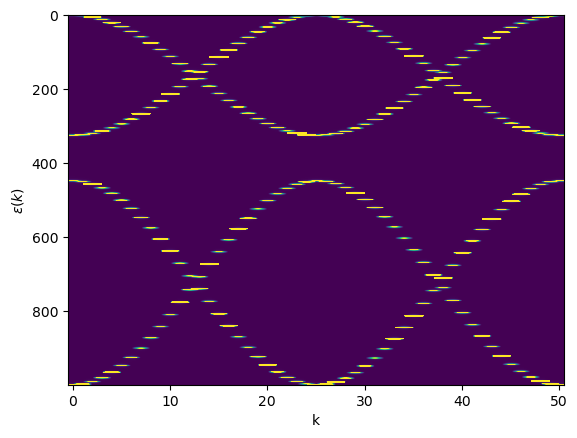

In [ ]:
# Calculate P_mK
# ------------------------------------------------------------------------------
def get_G_index(G, G_list):
    # Returns the index where the input vector G occurs in G_list.
    # Subtracts the vector G from each element in G_list. Then, finds index i
    # where G_list[i] < 1e-5
    G_list -= G
    return np.where(abs(G_list) < 1e-5)[0]

# Overlap matrix array
P_mK = np.zeros((N_kpts, N_grid, N_SC_states))

# For each k point
# ---------------------------
for ki, k in enumerate(kpts):
    
    # List of g+G0 values
    g_G0_list = g + G_unfold[ki]
    
    # Create a list of indices where G[i] has the value g+G0
    ig_G0_list = []
    for g_ in g_G0_list:
        ig_G0_list.append(get_G_index(g_, G.copy()))
    
    # Create P_m for the current k
    P_m = np.zeros((N_grid, N_SC_states))
    for m in range(N_SC_states):
        P = np.zeros((N_grid))
        norm = np.sum(np.linalg.norm(C_mK[:, :, ki, m])**2, axis=0)
        for iG in ig_G0_list:
            if np.size(iG) > 0:
                P += np.linalg.norm(C_mK[iG, :, ki, m])**2
        P_m[:,m] = P/norm
        
    # Add the P_m to the P_mK array
    P_mK[ki,:,:] += P_m
    
# Average over y-index
P_mK = np.sum(P_mK, axis=1)

# Calculate the spectral function
# ------------------------------------------------------------------------------
eta = 1e-5
N_epts = 1000
emin = np.min(SC_enk) - 5*eta
emax = np.max(SC_enk) + 5*eta

e = np.linspace(emin, emax, N_epts)

A_ke = np.zeros((N_kpts, N_epts), dtype=float)
for ki in range(N_kpts):
    for ei in range(len(SC_enk[ki, :])):
        em = SC_enk[ki, ei]
        d = (eta/np.pi)/((em - e)**2 + eta**2)
        A_ke[ki] += P_mK[ki, ei]*d

#A_ke /= np.max(A_ke)
plt.imshow(np.flip(A_ke).T, vmin=0, vmax=1, aspect='auto')
plt.xlabel('k')
plt.ylabel('$\epsilon(k)$')
plt.show()